In [1]:
import geemap
import ee
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib

## Load data and preprocess

In [3]:
df_final = pd.read_csv('carbon_stocks_cleaned_v4.csv')

In [14]:
df_final.columns

Index(['Unnamed: 0', '0-5cm', '5-15cm', '15-30cm', '30-60cm', '60-100cm',
       '100-200cm', '200-300cm', '0-30cm', '30-100cm', '100-300cm',
       'land_area', 'latitude', 'yedoma_soc_gt', 'C PF Area', 'D PF Area',
       'S PF Area', 'I PF Area', 'subsea_total', 'subsea 0-3m', 'subsea 3-25m',
       'subsea 25m plus'],
      dtype='object')

In [16]:
pf_cols = ['C PF Area', 'D PF Area', 'S PF Area', 'I PF Area']
depth_cols = ['0-5cm', '5-15cm', '15-30cm', '30-60cm', '60-100cm', '100-200cm', '200-300cm']

In [17]:
print('Soil Carbon total Gt:', df_final[depth_cols].sum().sum())
print('Yedoma Soil Carbon total Gt:', df_final['yedoma_soc_gt'].sum())
print('Total Land Area Mkm²:', df_final['land_area'].sum() * 1e-6)
print('Continuous PF Area Mkm²:', df_final['C PF Area'].sum() * 1e-6)
print('Discontinuous PF Area Mkm²:', df_final['D PF Area'].sum() * 1e-6)
print('Sporadic PF Area Mkm²:', df_final['S PF Area'].sum() * 1e-6)
print('Isolated PF Area Mkm²:', df_final['I PF Area'].sum() * 1e-6)
print('Subsea PF Carbon:', df_final['subsea_total'].sum())
print('Subsea PF Carbon 0-3m:', df_final['subsea 0-3m'].sum())
print('Subsea PF Carbon 3-25m:', df_final['subsea 3-25m'].sum())

Soil Carbon total Gt: 1524.1824061385569
Yedoma Soil Carbon total Gt: 455.96920142042904
Total Land Area Mkm²: 147.03774442197715
Continuous PF Area Mkm²: 10.974452099739993
Discontinuous PF Area Mkm²: 4.42054657131792
Sporadic PF Area Mkm²: 3.969377806321472
Isolated PF Area Mkm²: 3.8901797915413
Subsea PF Carbon: 2821.58
Subsea PF Carbon 0-3m: 92.66
Subsea PF Carbon 3-25m: 1217.14


## Plotting

/isipd/projects-noreplica/p_initze/anaconda3/envs/ML2/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:677: UserWarning: The label '_nolegend_' of <BarContainer object of 181 artists> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)
/isipd/projects-noreplica/p_initze/anaconda3/envs/ML2/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:677: UserWarning: The label '_nolegend_' of <BarContainer object of 181 artists> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)


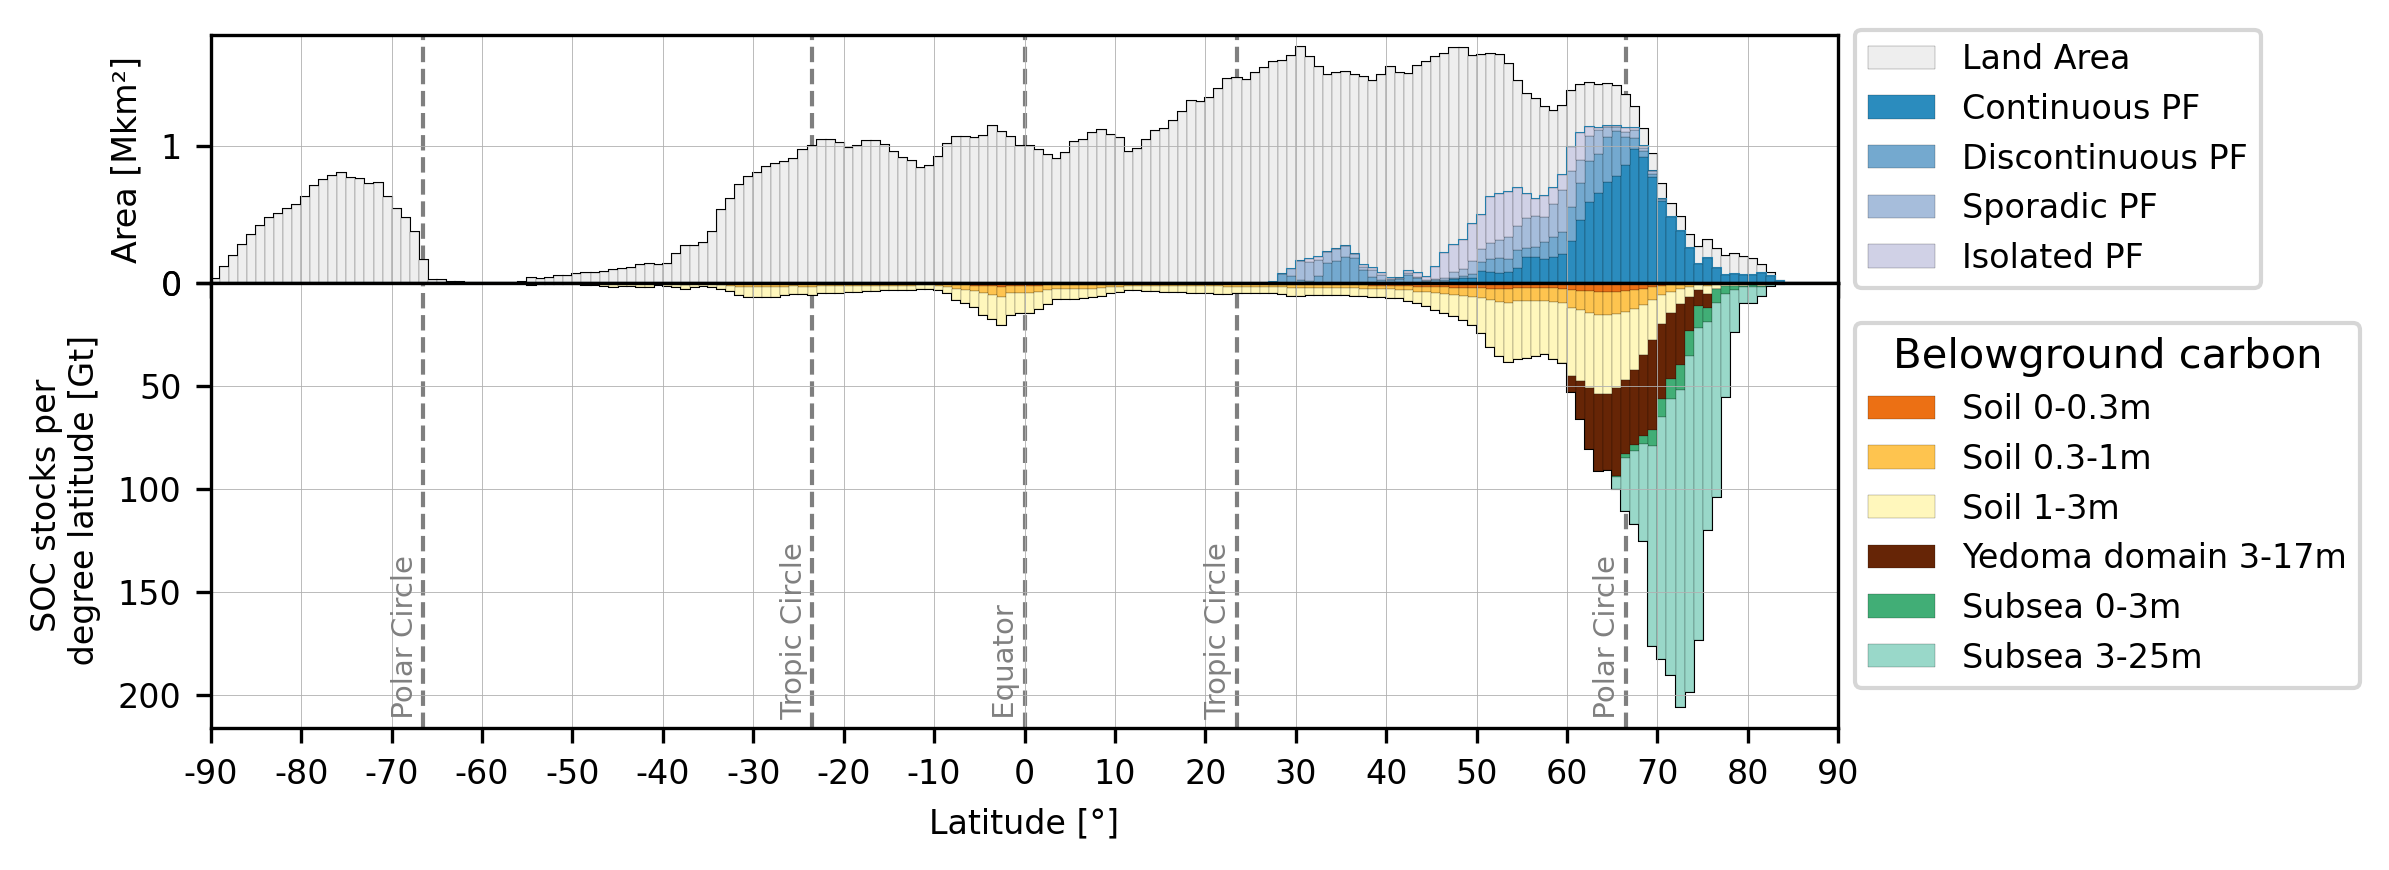

In [95]:
# Define your custom colors
colors_soil = ['#ec7014', '#fec44f', '#fff7bc', '#662506', '#41ae76', '#99d8c9']
colors_pf = ['#2b8cbe', '#74a9cf', '#a6bddb', '#d0d1e6']

plot_cols_soil = ['0-30cm', '30-100cm', '100-300cm', 'yedoma_soc_gt', 'subsea 0-3m', 'subsea 3-25m']

legend_labels_soil = ['Soil 0-0.3m', 'Soil 0.3-1m', 'Soil 1-3m', 'Yedoma domain 3-17m', 'Subsea 0-3m', 'Subsea 3-25m']
legend_labels_pf = ['Land Area', 'Continuous PF', 'Discontinuous PF', 'Sporadic PF', 'Isolated PF']

# viz params general
label_size = 8

# viz params bars
kwargs_bars = dict(width=1, edgecolor='black', lw=0.05, rot=0, align='edge')

# make a copy of original data
plot_data = df_final.copy()
plot_data['sum_carbon'] = df_final[plot_cols_soil].sum(axis=1)

# transform Area to million km² for better visualization
plot_data[['land_area', 'C PF Area', 'D PF Area', 'S PF Area', 'I PF Area']]*=1e-6
plot_data['sum_pf_area'] = plot_data[pf_cols].sum(axis=1)
# calculate sum of all


# Create your plot
fig, (ax2, ax) = plt.subplots(nrows=2, sharex=True, figsize=(7,3), dpi=300, height_ratios=(1,1.8))

ax = plot_data.plot(kind='bar', stacked=False, x='latitude', y='sum_carbon',
                     width=1, color=colors_soil, edgecolor='black', lw=0.5, rot=0, align='edge', ax=ax, fontsize=label_size, label='_nolegend_')
# plot carbon for defined sets (soil + yedoma + subsea)
ax = plot_data.plot(kind='bar', stacked=True, x='latitude', y=plot_cols_soil,
                     color=colors_soil, ax=ax, fontsize=label_size, **kwargs_bars)


# dummy bar to have nice outline for land area
_ = plot_data.plot(kind='bar', stacked=True, x='latitude', y='land_area',
                     width=1, color='#eeeeee', edgecolor='black', lw=0.5, rot=0, align='edge', ax=ax2, fontsize=label_size, label='_nolegend_')
# land area for upper ax 
ax2 = plot_data.plot(kind='bar', stacked=True, x='latitude', y='land_area',
                     color='#eeeeee', ax=ax2, fontsize=label_size, **kwargs_bars)
# dummy bar to have nice outline for permafrost
_ = plot_data.plot(kind='bar', stacked=True, x='latitude', y='sum_pf_area', 
                   width=1, color='#eeeeee', edgecolor='#2b8cbe', lw=0.5, rot=0, align='edge', ax=ax2, fontsize=label_size, label='_nolegend_')
# permafrost area for upper ax
ax2 = plot_data.plot(kind='bar', stacked=True, x='latitude', y=pf_cols,
                     color=colors_pf, ax=ax2, fontsize=label_size, **kwargs_bars)

# ax params
ax.invert_yaxis()
ax.set_ylabel('SOC stocks per\n degree latitude [Gt]', fontsize=label_size)
ax.set_xlabel('Latitude [°]', fontsize=label_size)
ax.grid(lw=0.2)
ax.set_xticks(np.arange(0,190,10), which='major')
ax.tick_params(axis='x', which='minor', bottom=False, top=False) #remove small tickmarks
ax.set_xlim(0,180)

# ax2 params
ax2.set_ylabel('Area [Mkm²]', fontsize=label_size)
ax2.set_xlabel('')
ax2.grid(lw=0.2)

# legend
ax.legend(legend_labels_soil, title='Belowground carbon', loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=label_size)
ax2.legend(legend_labels_pf, title=None, loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=label_size)

# Add vertical lines
kwargs_lat = dict(lw=1, alpha=0.5, linestyle='--', color='k', zorder=0)
for x in [-66.5, -23.5, 0, 23.5, 66.5]:
    ax.axvline(x=x+90, **kwargs_lat)  # 'k' is color code for black
    ax2.axvline(x=x+90, **kwargs_lat)  # 'k' is color code for black

# vline Annotations
annotate_padding = 0.5
kwargs_annotate = dict(textcoords="data",
                va="bottom", ha="right", rotation=90, fontsize=7, alpha=1, c='grey')
for x in [-66.5, 66.5]:   
    ax.annotate(" Polar Circle", (x+90-annotate_padding, ax.get_ylim()[0]), **kwargs_annotate)
for x in [-23.5, 23.5]:   
    ax.annotate(" Tropic Circle", (x+90-annotate_padding, ax.get_ylim()[0]), **kwargs_annotate)
for x in [0]:   
    ax.annotate(" Equator", (x+90-annotate_padding, ax.get_ylim()[0]), **kwargs_annotate)  


plt.subplots_adjust(hspace=0)

kwargs_fig = dict(bbox_inches='tight')
basename_fig = 'soil_carbon_v08'
fig.savefig(f'{basename_fig}.png', **kwargs_fig)
fig.savefig(f'{basename_fig}.svg', **kwargs_fig)